# Find Boat Ranges

TO DO:
- [X] add detection csv files to new madrid
- [X] change data paths for acoustic detection and object detection datasets
- [ ] create output dir on newmadrid
- [ ] change output path to newmadrid output dir

## Environment set-up
Load packages, connect google drive

In [1]:
# import packages
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic
import math


In [2]:
# make short path to data dir
datadir = '/Users/swbrown/Desktop/remote_data/d_sbrown/FKNMS/data/'
outdir = '/Users/swbrown/Desktop/remote_data/d_sbrown/FKNMS/output/'

## User-defined functions

In [3]:
# Function to check if each time is included in at least one record of the dataset
def is_time_in_dataset(times, dataset):
    is_match = []
    for time_to_check in times:
        time_in_records = ((time_to_check >= dataset['ISOStartTime'].dt.tz_localize(None) - pd.Timedelta(minutes = 15))
         & (time_to_check <= dataset['ISOEndTime'].dt.tz_localize(None) + pd.Timedelta(minutes = 15))).any()
        if time_in_records:
            is_match.append(True)
        else:
            is_match.append(False)

    return is_match

# Determine range grouping for each detection's distance from hydrophone
def find_range_group(distance):
  if distance <= 2000:
    return "<= 2 km"
  elif distance <= 5000:
    return "2 - 5 km"
  else:
    return "> 5 km"

# merge scenes
def merge_scenes(df):
    merged_data = []
    i = 0
    while i < len(df) - 1:
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]
        time_diff = (pd.to_datetime(next_row['sceneTime']) - pd.to_datetime(current_row['sceneTime'])).total_seconds()
        if time_diff <= 2:
            # Merge information of consecutive scenes
            merged_info = {
                'merged_timestamp': current_row['sceneTime'],  # You may adjust this to your preference
                'merged_info': {
                    'boats_combined': current_row['boat'] + next_row['boat'],
                    'wake_combined': current_row['boat_wake'] + next_row['boat_wake'],
                    'matches': [current_row['matches'],  next_row['matches']],
                    'scenes': [current_row['sceneTime'],  next_row['sceneTime']]
                    # Merge other relevant information as needed
                }
            }
            merged_data.append(merged_info)
            i += 2  # Move to the next pair of scenes
        else:
            # No merging, keep the current scene as is
            merged_data.append({
                'merged_timestamp': current_row['sceneTime'],
                'merged_info': {
                    'boats_combined': current_row['boat'] ,
                    'wake_combined': current_row['boat_wake'],
                    'matches': [current_row['matches']],
                    'scenes': [current_row['sceneTime']]
                }
            })
            i += 1
    return merged_data

# Function to calculate the azimuth between two points
def calculate_azimuth(point1, point2):
    lat1, lon1 = math.radians(point1.y), math.radians(point1.x)
    lat2, lon2 = math.radians(point2.y), math.radians(point2.x)
    
    dlon = lon2 - lon1
    x = math.cos(lat2) * math.sin(dlon)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    
    bearing = math.atan2(x, y)
    bearing = math.degrees(bearing)
    bearing = (bearing + 360) % 360  # Ensuring the bearing is between 0 and 360 degrees
    
    return bearing

## Load data

Note: Loading the detection dataset in a projected coordinate system UTM Zone 17N. New detections will not have any values in lat/lon column but all calculations will happen in the UTM CRS.

In [4]:
acoustic = pd.read_csv(os.path.join(datadir,"sanctsound_products_detections_fk01_sanctsound_fk01_01_ships_data_SanctSound_FK01_01_ships.csv"))
# make start and end times datetime variables
acoustic['ISOStartTime'] = pd.to_datetime(acoustic['ISOStartTime'])
acoustic['ISOEndTime'] = pd.to_datetime(acoustic['ISOEndTime'])

acoustic.head()

,ISOStartTime,ISOEndTime,Labels
0,2018-12-18 19:16:00+00:00,2018-12-18 19:38:10+00:00,ship
1,2018-12-18 19:44:40+00:00,2018-12-18 20:03:55+00:00,ship
2,2018-12-19 03:52:31+00:00,2018-12-19 04:09:16+00:00,ship
3,2018-12-19 13:11:53+00:00,2018-12-19 13:21:23+00:00,ship
4,2018-12-19 14:26:58+00:00,2018-12-19 14:37:08+00:00,ship


In [37]:
# Read in verified detection table
# Note planet imagery timestamp is in UTC
planet = pd.read_csv(os.path.join(datadir,"verified/wdr_2019_DetectionTable.csv"))
planet['sceneName'] = planet['chipName'].str.split("_clip").str.get(0)
planet['sceneTime'] = pd.to_datetime(planet['sceneName'].str[:15], format='%Y%m%d_%H%M%S')

planet = gpd.GeoDataFrame(
    planet, geometry=gpd.points_from_xy(planet.x, planet.y), crs="EPSG:32617"
)

print(f"Number of detections: {planet.shape}")

# filter out scenes that are "invalid"
badScenes = ['20190122_152020_100d_3B_Visual','20190214_151824_104e_3B_Visual',
             '20190214_151825_104e_3B_Visual','20190625_154315_1006_3B_Visual',
             '20190625_154316_1006_3B_Visual','20190721_155428_42_1064_3B_Visual',
             '20190831_155614_61_1057_3B_Visual', '20190923_154309_0f52_3B_Visual',
             '20190923_154310_0f52_3B_Visual','20190306_153747_1004_3B_Visual']

planet = planet[~planet['sceneName'].isin(badScenes)]

print(f"Number of detections with scenes removed: {planet.shape}")

# remove "new detections"
planet = planet[planet['class'] != 'new_detection']

print(f"Number of detections with scenes removed: {planet.shape}")

# remove "bad" detections
planet = planet[planet['verification'] != "bad"]
print(f"Number of detections with bad detections removed: {planet.shape}")

# make "new_class" detections boat/boat_wake and make "verification" = "added"

# First add verification status
mask = (planet['class'] == 'new_boat') | (planet['class'] == "new_wake")
planet.loc[mask, 'verification'] = 'added'

# then use "replace" function to make new_boat = boat and new_wake = boat_wake
planet['class'].replace({'new_boat': 'boat', 'new_wake': 'boat_wake'}, inplace=True)


Number of detections: (12582, 14)
Number of detections with scenes removed: (11903, 14)
Number of detections with scenes removed: (11718, 14)
Number of detections with bad detections removed: (11657, 14)


/var/folders/rp/fs4mrjt96mldt29hv296qct00000gq/T/ipykernel_84407/3058961301.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  planet['class'].replace({'new_boat': 'boat', 'new_wake': 'boat_wake'}, inplace=True)


In [38]:
planet['class'].value_counts()

class
none         9139
boat         2016
boat_wake     502
Name: count, dtype: int64

In [39]:
planet['verification'].value_counts() # bad ones removed

verification
added            185
misclassified     19
Name: count, dtype: int64

In [40]:
planet = planet[planet['class'] != 'none']

In [41]:
wdr = Point([-81.93068000000001,24.43313])
wdr = gpd.GeoDataFrame(geometry=[wdr], crs="EPSG:4326")  # Set CRS to EPSG:4326

# Reproject the GeoDataFrame to a new CRS (e.g., EPSG:32610, UTM Zone 10N)
wdr_utm = wdr.to_crs("EPSG:32617")  # Reproject to same CRS as detection df
wdr_utm_point = wdr_utm.geometry.iloc[0]

planet['dist_to_hydrophone'] = planet.geometry.distance(wdr_utm_point)

In [42]:
# reproject to EPSG:4326
planet = planet.to_crs("EPSG:4326")  # Reproject to sameCRS as detection df
planet['azimuth'] = planet['geometry'].apply(lambda x: calculate_azimuth(x, wdr.geometry.iloc[0])) 


In [44]:
# Get list of images (no r_ c_)

# reduce dataset to match the deployment start end times in NOAA dataset
latest_time = acoustic['ISOEndTime'].max()
latest_time = latest_time.date() + pd.Timedelta(days = 1)

dep1 = planet[planet['sceneTime'] < pd.to_datetime(latest_time)]

# Get list of images (no r_ c_)
imageTimes = dep1['sceneTime'].unique()

In [45]:
matches = is_time_in_dataset(imageTimes, acoustic)
checkImages = pd.DataFrame(data = {'sceneTime': imageTimes,'matches': matches})

In [46]:
df = pd.merge(dep1, checkImages, how = 'left', on = 'sceneTime')

In [47]:
#df = df[df['class'] != 'none']
df.shape

(1151, 17)

In [50]:
df['range_group'] = df['dist_to_hydrophone'].apply(find_range_group)

# Define the order of facet levels
facet_order = ['<= 2 km', '2 - 5 km', '> 5 km']

# Convert facet_var to categorical with defined order
df['range_group'] = pd.Categorical(df['range_group'], categories=facet_order, ordered=True)


In [58]:

mod_df = df[['class','sceneTime', 'geometry','azimuth', 'dist_to_hydrophone', 'matches']]
mod_df['lat'] = mod_df['geometry'].apply(lambda point: point.y)
mod_df['lon'] = mod_df['geometry'].apply(lambda point: point.x)
mod_df.drop(columns = ['geometry'], inplace = True)
#df.to_csv(os.path.join(outdir,"wdr_detection_info.csv"), index = False)
mod_df.to_csv(os.path.join(outdir,"wdr_detection_info.csv"), index = False)

/opt/anaconda3/envs/boat-detection/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/boat-detection/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/rp/fs4mrjt96mldt29hv296qct00000gq/T/ipykernel_84407/2323629458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [52]:
df.columns

Index(['chipName', 'chipTime', 'class', 'x', 'y', 'w', 'h', 'conf', 'lat',
       'lon', 'verification', 'sceneName', 'sceneTime', 'geometry',
       'dist_to_hydrophone', 'azimuth', 'matches', 'range_group'],
      dtype='object')

## Visualizations

<Axes: ylabel='Frequency'>

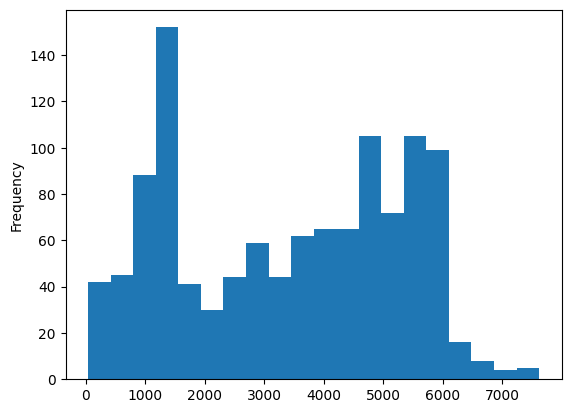

In [ ]:
df['dist_to_hydrophone'].plot.hist(bins = 20)

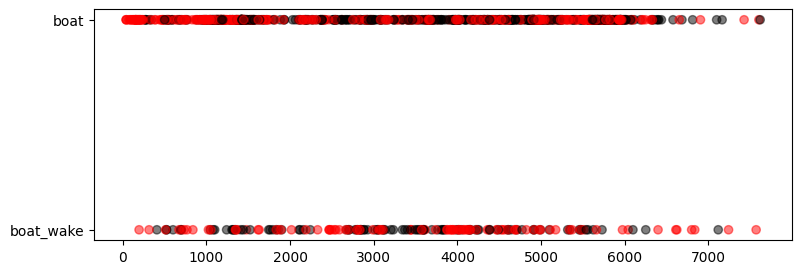

In [ ]:
colors = {True: 'red', False: 'black'}

df['marker_color'] = df['matches'].map(colors)

plt.figure(figsize=(9, 3))

plt.scatter(df['dist_to_hydrophone'], df['class'], c=df['marker_color'],alpha = 0.5)


<Axes: xlabel='class', ylabel='dist_to_hydrophone'>

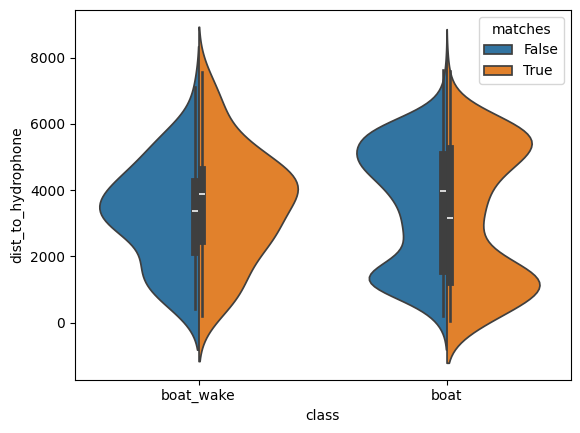

In [ ]:
sns.violinplot(data=df, x='class', y='dist_to_hydrophone', hue='matches', split=True)


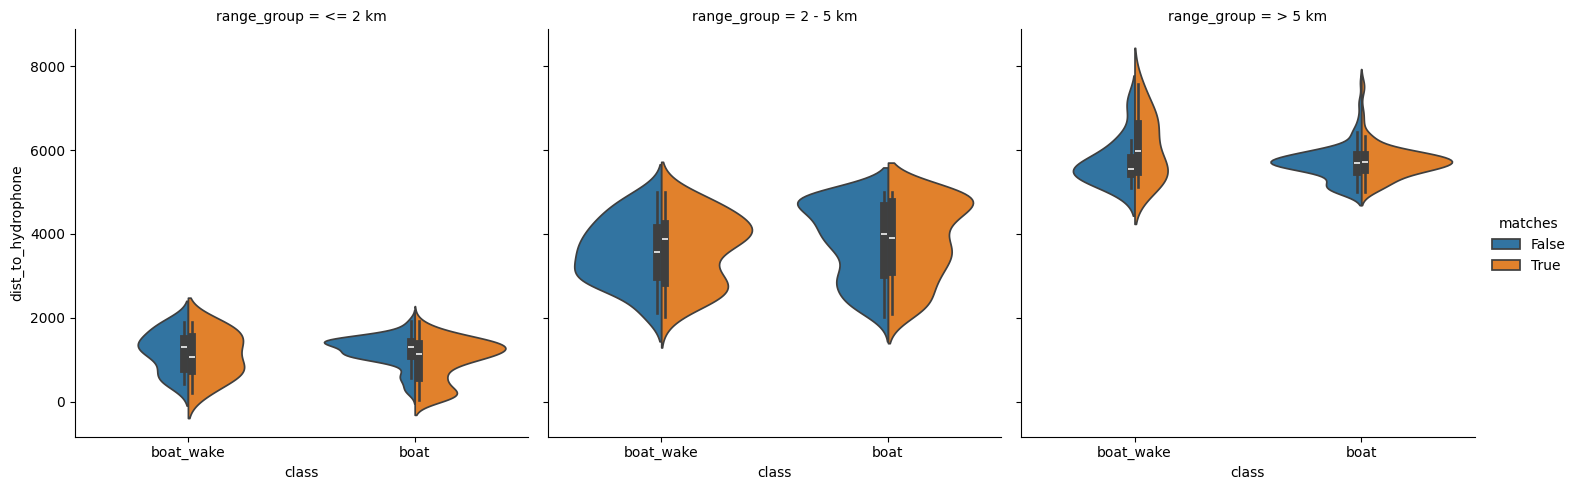

In [ ]:
sns.catplot(x='class', y='dist_to_hydrophone', hue='matches',
            col='range_group', kind='violin', split=True, data=df)


## Summaries


In [ ]:
summary_df = df.groupby(['sceneTime', 'class']).size().unstack(fill_value=0)
summary_df = pd.merge(summary_df,checkImages, how = 'left', on = 'sceneTime')
summary_df

class,boat,boat_wake,none
sceneTime,,,
2019-01-01 15:24:15,0,1,33
2019-01-03 15:38:48,17,5,37
2019-01-03 15:38:49,3,2,25
2019-01-06 15:38:33,7,1,40
2019-01-06 15:38:34,6,1,31
...,...,...,...
2019-04-18 15:39:21,8,2,37
2019-04-19 15:09:28,9,0,39
2019-04-19 15:09:29,2,0,26


In [ ]:
merged_scenes= merge_scenes(summary_df)

In [ ]:
merged_df = pd.DataFrame(merged_scenes)
merged_df

,merged_timestamp,merged_info
0,2019-01-01 15:24:15,"{'boats_combined': 0, 'wake_combined': 1, 'mat..."
1,2019-01-03 15:38:48,"{'boats_combined': 20, 'wake_combined': 7, 'ma..."
2,2019-01-06 15:38:33,"{'boats_combined': 13, 'wake_combined': 2, 'ma..."
3,2019-01-08 15:31:45,"{'boats_combined': 11, 'wake_combined': 2, 'ma..."
4,2019-01-09 15:38:16,"{'boats_combined': 30, 'wake_combined': 1, 'ma..."
...,...,...
60,2019-04-13 15:42:43,"{'boats_combined': 2, 'wake_combined': 1, 'mat..."
61,2019-04-15 15:38:52,"{'boats_combined': 4, 'wake_combined': 4, 'mat..."
62,2019-04-18 15:39:20,"{'boats_combined': 14, 'wake_combined': 2, 'ma..."
63,2019-04-19 15:09:28,"{'boats_combined': 11, 'wake_combined': 0, 'ma..."


In [ ]:
merged_df['merged_timestamp'].to_csv("merged_sceneTimes.csv", index = False)

<Axes: xlabel='sceneTime', ylabel='boat'>

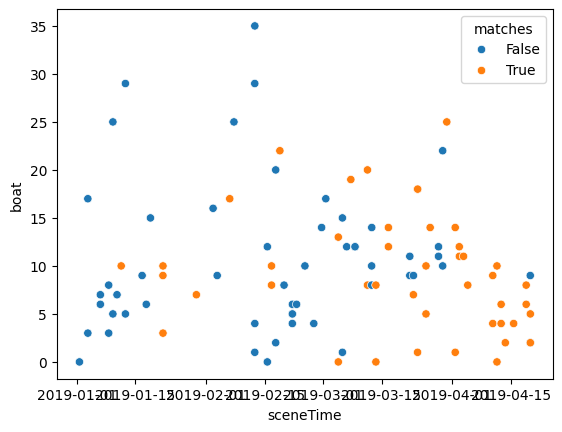

In [ ]:
sns.scatterplot(data=summary_df, x = "sceneTime", y = 'boat',hue = "matches")

<Axes: xlabel='sceneTime', ylabel='boat_wake'>

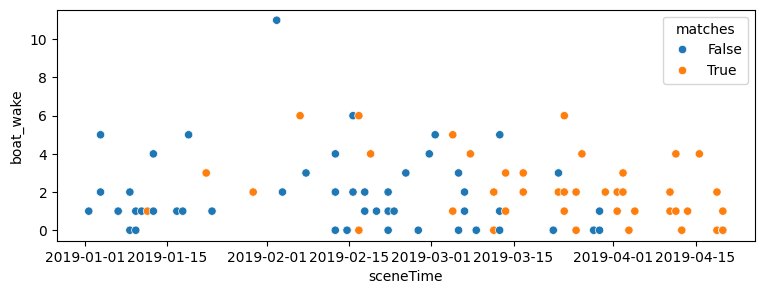

In [ ]:
fig, ax = plt.subplots(figsize=(9, 3))

sns.scatterplot(data=summary_df, x = "sceneTime", y = 'boat_wake',hue = "matches")

<Axes: xlabel='Month', ylabel='count'>

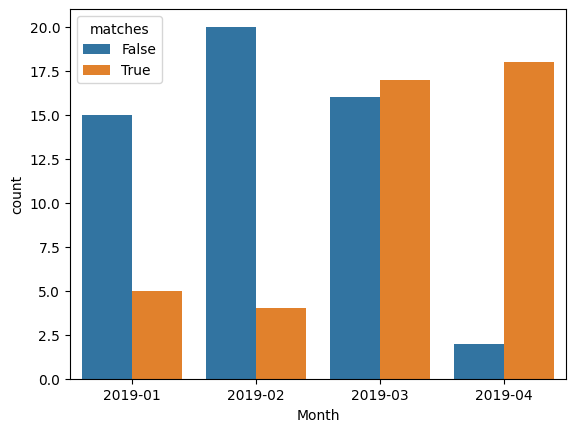

In [ ]:
summary_df['Month'] = summary_df['sceneTime'].dt.to_period('M')
sns.countplot(data = summary_df, x = 'Month', hue = 'matches' )

<Axes: xlabel='Month', ylabel='count'>

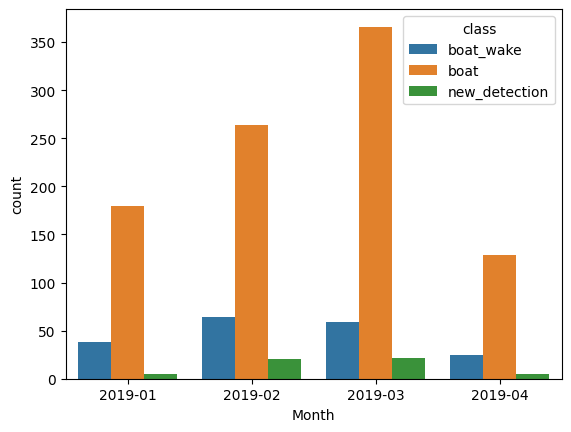

In [ ]:

df['Month'] = df['sceneTime'].dt.to_period('M')

sns.countplot(data = df, x = 'Month', hue = 'class' )

In [ ]:
df2 = pd.merge(dep1, checkImages, how = 'left', on = 'sceneTime')

In [ ]:
byclass = df2.groupby(['sceneTime', 'class']).size().unstack(fill_value=0)
byclass.head()

class,boat,boat_wake,none
sceneTime,,,
2019-01-01 15:24:15,0,1,33
2019-01-03 15:38:48,17,5,37
2019-01-03 15:38:49,3,2,25
2019-01-06 15:38:33,7,1,40
2019-01-06 15:38:34,6,1,31


In [ ]:
byclass = pd.merge(byclass,checkImages, how = 'left', on = 'sceneTime')

In [ ]:
byclass

,sceneTime,boat,boat_wake,none,matches
0,2019-01-01 15:24:15,0,1,33,False
1,2019-01-03 15:38:48,17,5,37,False
2,2019-01-03 15:38:49,3,2,25,False
3,2019-01-06 15:38:33,7,1,40,False
4,2019-01-06 15:38:34,6,1,31,False
...,...,...,...,...,...
96,2019-04-18 15:39:21,8,2,37,True
97,2019-04-19 15:09:28,9,0,39,False
98,2019-04-19 15:09:29,2,0,26,False
99,2019-04-19 15:39:57,2,1,33,True


## Old code

In [ ]:
#Figure out which scenes from WDR we need to re-label the new detections

new = planet[planet['class'] == 'new_detection']
new_scenes = list(new['sceneName'].unique())

verified = planet[planet['class'] != 'new_detection']
verified_scenes = list(verified['sceneName'].unique())

processed_scenes = []
for s in verified_scenes:
  if s not in new_scenes:
    processed_scenes.append(s)

p = pd.DataFrame({'imgName': processed_scenes})
p.to_csv('processed.csv', index = False)